# Let us Import all the necessary libraries


In [2]:
# All the imports
import torch 
import pandas as pd
from ultralytics import YOLO
import matplotlib.pyplot as plt
import cv2
import numpy as np
from skimage.draw import line
from sklearn.cluster import DBSCAN
from sklearn.neighbors import LocalOutlierFactor
import alphashape
from scipy.interpolate import splprep, splev
from shapely.geometry import Point, Polygon

# All the Helper Functions required


In [3]:

def expand_crop(x1, y1, x2, y2, padding, img_shape):
    '''
    This function takes in coordinates, adds some padding to coordinates ensuring all values are within limits
    It returns the expanded crop coordinates so that our search space is concise but not too restricted with initial coordinates
    '''
    h, w = img_shape[:2]
    x1_p = max(0, x1 - padding)
    y1_p = max(0, y1 - padding)
    x2_p = min(w, x2 + padding)
    y2_p = min(h, y2 + padding)
    return x1_p, y1_p, x2_p, y2_p

In [4]:
import cv2
import numpy as np 
def detect_circle(img,minR,maxR):
    '''
    It takes in an image, minR (min Radius) and maxR (maximum Radius) as inputs
    Detects circle in the image based on minR and maxR
    returns the resized centre and radius of the circle
    It is resized to 640,640 to set a standard
    '''
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Apply Gaussian Blur to reduce noise (important for HoughCircles)
    blurred = cv2.GaussianBlur(gray, (9, 9), 2)

    # Detect circles using HoughCircles
    circles = cv2.HoughCircles(
        blurred,
        cv2.HOUGH_GRADIENT,
        dp=1.2,
        minDist=100,
        param1=50,   # Higher threshold for internal Canny (not related to Canny usage outside Hough)
        param2=40,   # Circle detection threshold (reduce if nothing found)
        minRadius=minR,
        maxRadius=maxR
    )

    output = img.copy()
    # Draw the largest detected circle
    if circles is not None:
        # Round and take only the first circle
        x, y, r = np.round(circles[0][0]).astype("int")


    H_orig, W_orig = output.shape[:2]

    # Resize target
    H_new, W_new = 640, 640

    # Scaling factors
    scale_x = W_new / W_orig
    scale_y = H_new / H_orig

    # Rescaled circle center and radius
    cx_resized = int(x * scale_x)
    cy_resized = int(y * scale_y)
    r_resized  = int(r * (scale_x + scale_y) / 2)

    return cx_resized,cy_resized,r_resized

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.draw import line

def extract_radial_profiles(image, cx, cy, radius, angle_step=15):
    '''
    This function takes the inputs Image on which we want the radial intensity profile
    This function specifically used to extract radial profile intensities in a circle with centre cx, cy 
    The parameter angle_step can be explicitly given or it is default 15 degree
    This function returns the profiles and angles
    profiles is a list of tuples, which contains intensities in 0th index and distance from centre for that respective intensity
    angles is a list of angles from 0 to 360 with a step of angle_step
    '''

    profiles = []
    angles = np.deg2rad(np.arange(0, 360, angle_step))

    for theta in angles:
        x_end = int(round(cx + radius * np.cos(theta)))
        y_end = int(round(cy + radius * np.sin(theta)))

        rr, cc = line(int(round(cy)), int(round(cx)), y_end, x_end)

        valid_intensities = []
        valid_distances = []

        for r, c in zip(rr, cc):
            if 0 <= r < image.shape[0] and 0 <= c < image.shape[1]:
                intensity = image[r, c]
                distance = np.sqrt((c - cx)**2 + (r - cy)**2)

                valid_intensities.append(intensity)
                valid_distances.append(distance)

        profiles.append((np.array(valid_intensities, dtype=np.float32),
                         np.array(valid_distances, dtype=np.float32)))

    return profiles, angles

In [6]:
def min_int_points(profiles,angles,cx,cy):

    '''
    This takes in the profiles and angles computed previously
    Takes the minimum of intensities plotted in each profile and returns the coordinate, so we can visualize exactly where the point is
    It returns a tuple/ stack in which 0th index is x coordinate and 1st index is y coordinate
    '''
    
    x_min_int_processed,y_min_int_processed=[],[]

    for idx, (intensities, distances) in enumerate(profiles):
        if len(intensities) < 10:
            continue
            
        y = np.asarray(intensities, dtype=np.float32)   
        t = np.asarray(distances, dtype=np.float32)

            # Sort by distance (just in case)
        sort_idx = np.argsort(t)
        t = t[sort_idx]
        y = y[sort_idx]

            # Ensure correct shape: (N,) not (N,1)
        y = y.flatten()
        t = t.flatten()

        angle_rad=angles[idx]

        min_int=np.argmin(y)
        x_min=cx+t[min_int]*np.cos(angle_rad)
        y_min=cy+t[min_int]*np.sin(angle_rad)
            
        x_min_int_processed.append(x_min)
        y_min_int_processed.append(y_min)

    return np.column_stack((x_min_int_processed,y_min_int_processed))

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.neighbors import LocalOutlierFactor
import alphashape
from scipy.interpolate import splprep, splev
import cv2

def get_smooth_alpha_shape(img,points,smooth,a=0.02):

    '''
    This function takes in the img in which the spot is to be detected
    This function takes the points of minimum intensities computed in min_int_points()
    This function returns the smoothened alpha shape points bounding the min_int_points()
    The logic is minimum intensities are in spot region so it bounds the spot, but it is smoothened for better result
    The points returned is the smoothened alpha shape contour points which are further used
    '''
    crop_again=img
    db = DBSCAN(eps=30, min_samples=3).fit(points)
    labels = db.labels_

    # Keep only dense points (label != -1)
    dense_points = points[labels != -1]


    # Step 2: Apply LOF for outlier detection
    lof = LocalOutlierFactor(n_neighbors=100, contamination=0.05)
    labels_lof = lof.fit_predict(dense_points)  # 1 = inlier, -1 = outlier

    # Step 3: Separate inliers and outliers
    inliers = dense_points[labels_lof == 1]
    outliers = dense_points[labels_lof == -1]

    alpha = a # Adjust as needed (lower = tighter boundary)

    shape = alphashape.alphashape(inliers, alpha)

    if shape.geom_type == 'Polygon':
        x, y = shape.exterior.xy
    elif shape.geom_type == 'MultiPolygon':
        for polygon in shape.geoms:
            x, y = polygon.exterior.xy

    alphamask_processed = np.ones_like(crop_again, dtype=np.uint8)


    x, y = shape.exterior.xy
    shape_points = np.array([x, y])
    tck, u = splprep(shape_points, s=smooth, per=True)
    x_smooth, y_smooth = splev(np.linspace(0, 1, 400), tck)

    contour = np.stack((x_smooth, y_smooth), axis=-1).astype(np.int32)
    cv2.fillPoly(alphamask_processed, [contour], 0)

    return np.column_stack((x_smooth,y_smooth))

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.neighbors import LocalOutlierFactor
import alphashape
from scipy.interpolate import splprep, splev
import cv2
from shapely.geometry import Polygon, MultiPolygon

def get_smooth_alpha_shape_v2(img, points, smooth,a=0.02):
    '''
    This function takes in the img in which the spot is to be detected.
    It takes the points of minimum intensities computed in min_int_points().
    It returns the smoothened alpha shape points bounding the min_int_points().
    '''
    crop_again = img
    # db = DBSCAN(eps=30, min_samples=10).fit(points)
    # labels = db.labels_

    # # Keep only dense points (label != -1)
    # dense_points = points[labels != -1]

    # Step 2: Apply LOF for outlier detection
    lof = LocalOutlierFactor(n_neighbors=100, contamination=0.05)
    labels_lof = lof.fit_predict(points)  # 1 = inlier, -1 = outlier

    # Step 3: Separate inliers and outliers
    inliers = points[labels_lof == 1]

    alpha = a  # Adjust as needed (lower = tighter boundary)
    shape = alphashape.alphashape(points, alpha)

    # Convert MultiPolygon to largest Polygon if needed
    if isinstance(shape, MultiPolygon):
        shape = max(shape.geoms, key=lambda p: p.area)

    if not isinstance(shape, Polygon):
        raise ValueError("Alpha shape did not result in a valid Polygon.")

    center=shape.centroid
    # Now process the polygon
    x, y = shape.exterior.xy
    shape_points = np.array([x, y])
    tck, _ = splprep(shape_points, s=smooth, per=True)
    x_smooth, y_smooth = splev(np.linspace(0, 1, 400), tck)

    contour = np.stack((x_smooth, y_smooth), axis=-1).astype(np.int32)
    
    alphamask_processed = np.ones_like(crop_again, dtype=np.uint8)
    cv2.fillPoly(alphamask_processed, [contour], 0)

    return np.column_stack((x_smooth, y_smooth)), center


In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.neighbors import LocalOutlierFactor
import alphashape
from scipy.interpolate import splprep, splev
import cv2
from shapely.geometry import Polygon, MultiPolygon

def get_smooth_alpha_shape_v3(img, points, smooth,a=0.02):
    '''
    This function takes in the img in which the spot is to be detected.
    It takes the points of minimum intensities computed in min_int_points().
    It returns the smoothened alpha shape points bounding the min_int_points().
    '''
    crop_again = img
    db = DBSCAN(eps=30, min_samples=10).fit(points)
    labels = db.labels_
    
    # Keep only dense points (label != -1)
    dense_points = points[labels != -1]

    # Step 2: Apply LOF for outlier detection
    lof = LocalOutlierFactor(n_neighbors=100, contamination=0.05)
    labels_lof = lof.fit_predict(dense_points)  # 1 = inlier, -1 = outlier

    # Step 3: Separate inliers and outliers
    inliers = dense_points[labels_lof == 1]

    alpha = a  # Adjust as needed (lower = tighter boundary)
    shape = alphashape.alphashape(inliers, alpha)

    # Convert MultiPolygon to largest Polygon if needed
    if isinstance(shape, MultiPolygon):
        shape = max(shape.geoms, key=lambda p: p.area)

    if not isinstance(shape, Polygon):
        raise ValueError("Alpha shape did not result in a valid Polygon.")

    center=shape.centroid
    # Now process the polygon
    x, y = shape.exterior.xy
    shape_points = np.array([x, y])
    tck, _ = splprep(shape_points, s=smooth, per=True)
    x_smooth, y_smooth = splev(np.linspace(0, 1, 400), tck)

    contour = np.stack((x_smooth, y_smooth), axis=-1).astype(np.int32)
    
    alphamask_processed = np.ones_like(crop_again, dtype=np.uint8)
    cv2.fillPoly(alphamask_processed, [contour], 0)

    return np.column_stack((x_smooth, y_smooth)), center


In [10]:
def scale_polygon_points(points, scale=1.1):

    '''
    This function is used to increase/decrease the alpha shape.
    '''
    # Step 1: Compute centroid
    centroid = np.mean(points, axis=0)

    # Step 2: Shift points to origin, scale, shift back
    scaled_points = (points - centroid) * scale + centroid
    return scaled_points

In [11]:
def scale_polygon_points(points, scale=1.1, offset=(0, 0)):
    '''
    Scales the polygon around its centroid, and then applies an (x, y) offset.

    Parameters:
    - points: Nx2 numpy array of (x, y) points
    - scale: float, scaling factor (e.g. 1.1 to enlarge, 0.9 to shrink)
    - offset: tuple (dx, dy), shift in pixels after scaling
              dx > 0 => right, dx < 0 => left
              dy > 0 => down, dy < 0 => up
    '''
    # Step 1: Compute centroid
    centroid = np.mean(points, axis=0)

    # Step 2: Scale about centroid
    scaled_points = (points - centroid) * scale + centroid

    # Step 3: Apply offset
    dx, dy = offset
    scaled_points[:, 0] += dx  # x-direction (horizontal)
    scaled_points[:, 1] += dy  # y-direction (vertical)

    return scaled_points


In [12]:
from skimage.draw import line
from shapely.geometry import Point, Polygon
import numpy as np

def extract_radial_profiles_in_region(image, cx, cy, radius, region, angle_step=15):
    """
    Extract radial profiles only for pixels inside a polygonal region.
    
    Parameters:
    - image: 2D grayscale image
    - cx, cy: center point
    - radius: max radius of sampling
    - region: list or array of (x, y) points defining the polygon
    - angle_step: angle step in degrees
    
    Returns:
    - profiles: list of (intensities, distances) for each angle
    - angles: list of angles (in radians)
    """
    polygon = Polygon(region)  # Create region polygon
    profiles = []
    angles = np.deg2rad(np.arange(0, 360, angle_step))

    for theta in angles:
        x_end = int(round(cx + radius * np.cos(theta)))
        y_end = int(round(cy + radius * np.sin(theta)))

        rr, cc = line(int(round(cy)), int(round(cx)), y_end, x_end)

        valid_intensities = []
        valid_distances = []

        for r, c in zip(rr, cc):
            if 0 <= r < image.shape[0] and 0 <= c < image.shape[1]:
                # Only include if point is inside the region
                if polygon.contains(Point(c, r)):
                    intensity = image[r, c]
                    distance = np.sqrt((c - cx)**2 + (r - cy)**2)

                    valid_intensities.append(intensity)
                    valid_distances.append(distance)

        profiles.append((np.array(valid_intensities, dtype=np.float32),
                         np.array(valid_distances, dtype=np.float32)))

    return profiles, angles

In [13]:
from scipy.interpolate import splprep, splev
import numpy as np
import matplotlib.pyplot as plt

def smooth_closed_curve(points, smoothness=0):

    ''' 
    It takes in the contour points, and smoothens them and returns the smooth points
    particularly useful when iterative smoothening is done
    '''
    points = np.array(points)
    # Ensure closed by repeating the first point at the end if needed
    if not np.allclose(points[0], points[-1]):
        points = np.vstack([points, points[0]])

    # Fit a periodic spline (closed curve)
    tck, u = splprep([points[:,0], points[:,1]], s=smoothness, per=True)

    # Evaluate spline at many points for smoothness
    u_fine = np.linspace(0, 1, 500)
    x_smooth, y_smooth = splev(u_fine, tck)
    return np.column_stack([x_smooth, y_smooth])

In [14]:
def trim_points_inside_circle(points, center, radius):
    """
    Filters points to retain only those inside a circle.

    Parameters:
    - points: Nx2 numpy array of (x, y) coordinates
    - center: (x, y) tuple for circle center
    - radius: radius of the circle

    Returns:
    - trimmed_points: points inside the circle
    """
    cx, cy = center
    distances = np.sqrt((points[:, 0] - cx) ** 2 + (points[:, 1] - cy) ** 2)
    mask = distances <= radius
    return points[mask]

In [15]:
import numpy as np

def merge_trim_with_circle_by_radial_sweep(trim_points, circle_center, radius, resolution_deg=1):
    """
    Rotates a line from the circle center, at each angle checks if a trim point is on that line;
    if yes, takes the nearest trim point; else takes the circle point.

    Parameters:
    - trim_points: Nx2 array of trimmed (x, y) points
    - circle_center: (cx, cy)
    - radius: float, radius of the reference circle
    - resolution_deg: angle step in degrees

    Returns:
    - merged_points: (M, 2) array of points forming the new merged contour
    """
    cx, cy = circle_center
    trim_points = np.array(trim_points)
    rel_trim = trim_points - np.array([cx, cy])
    merged_points = []

    for deg in range(0,360 , resolution_deg):
        theta = np.deg2rad(deg)
        dir_vec = np.array([np.cos(theta), np.sin(theta)])

        # Project all trim points onto this direction
        dot_proj = rel_trim @ dir_vec
        angle_diff = np.arctan2(rel_trim[:,1], rel_trim[:,0]) - theta
        angle_diff = np.arctan2(np.sin(angle_diff), np.cos(angle_diff))  # wrap to [-π, π]
        
        # Keep points within ±half_res_deg tolerance
        tolerance = np.deg2rad(resolution_deg / 2)
        mask = np.abs(angle_diff) < tolerance

        if np.any(mask):
            candidates = trim_points[mask]
            dists = np.linalg.norm(candidates - np.array([cx, cy]), axis=1)
            closest_point = candidates[np.argmin(dists)]
            merged_points.append(closest_point)
        else:
            # Use circle point
            x = cx + radius * np.cos(theta)
            y = cy + radius * np.sin(theta)
            merged_points.append([x, y])

    return np.array(merged_points)


In [16]:
import numpy as np
from skimage.draw import line
import matplotlib.pyplot as plt

def merge_using_skimage_line(trim_points, circle_center, radius, image_shape, resolution_deg=1):
    cx, cy = int(circle_center[0]), int(circle_center[1])
    trim_mask = np.zeros(image_shape, dtype=bool)

    # Mark trim points on a mask
    for x, y in trim_points.astype(int):
        if 0 <= y < image_shape[0] and 0 <= x < image_shape[1]:
            trim_mask[y, x] = True

    merged_points = []
    for angle_deg in range(0, 360, resolution_deg):
        angle_rad = np.deg2rad(angle_deg)
        x_end = int(cx + radius * np.cos(angle_rad))
        y_end = int(cy + radius * np.sin(angle_rad))

        rr, cc = line(cy, cx, y_end, x_end)  # skimage uses (row, col) = (y, x)

        found = False
        for r, c in zip(rr, cc):
            if 0 <= r < image_shape[0] and 0 <= c < image_shape[1]:
                if trim_mask[r, c]:
                    merged_points.append([c, r])  # (x, y)
                    found = True
                    break

        if not found:
            merged_points.append([x_end, y_end])  # use circle point

    return np.array(merged_points)


In [17]:
def pre_process(gray_img):
    '''      
    Takes input as a gray image, applies required pre processing and gives the processed image
    '''
    copy = cv2.equalizeHist(gray_img)
    sobel_x = cv2.Sobel(copy, cv2.CV_64F, 1, 0, ksize=3)
    sobel_y = cv2.Sobel(copy, cv2.CV_64F, 0, 1, ksize=3)
    sobel = cv2.magnitude(sobel_x, sobel_y)
    sobel= cv2.convertScaleAbs(sobel)
    copy = cv2.GaussianBlur(sobel, (5, 5), 0)

    return copy

In [18]:
def interpolate_upper_to_circle(alpha_contour, circle_center, radius, y_threshold):
    cx, cy = circle_center
    updated_contour = []

    for x, y in alpha_contour:
        if y < y_threshold:
            # Compute angle from center
            angle = np.arctan2(y - cy, x - cx)
            # Point on circle at this angle
            new_x = cx + radius * np.cos(angle)
            new_y = cy + radius * np.sin(angle)
            updated_contour.append([new_x, new_y])
        else:
            updated_contour.append([x, y])

    return np.array(updated_contour)


In [19]:
import numpy as np

def merge_trim_with_circle_upper_arc_only(trim_points, circle_center, radius, resolution_deg=1):
    """
    Merges trim points with a circular arc in the upper half (y < cy), preserving the trim shape below.

    Parameters:
    - trim_points: Nx2 array of trimmed (x, y) points
    - circle_center: (cx, cy)
    - radius: float, radius of the reference circle
    - resolution_deg: angle step in degrees

    Returns:
    - merged_points: (M, 2) array of merged contour points
    """
    cx, cy = circle_center
    trim_points = np.array(trim_points)
    rel_trim = trim_points - np.array([cx, cy])
    merged_points = []

    for deg in range(0, 360, resolution_deg):
        theta = np.deg2rad(deg)
        dir_vec = np.array([np.cos(theta), np.sin(theta)])

        # Project all trim points onto this direction
        angle_diff = np.arctan2(rel_trim[:,1], rel_trim[:,0]) - theta
        angle_diff = np.arctan2(np.sin(angle_diff), np.cos(angle_diff))  # wrap to [-π, π]
        
        tolerance = np.deg2rad(resolution_deg / 2)
        mask = np.abs(angle_diff) < tolerance

        if np.any(mask):
            candidates = trim_points[mask]
            dists = np.linalg.norm(candidates - np.array([cx, cy]), axis=1)
            closest_point = candidates[np.argmin(dists)]
            x_cand, y_cand = closest_point

            # For upper half, use circle if no candidate; else use closest point
            if y_cand < cy:
                # If candidate exists, still check whether to use circle or not
                merged_points.append([cx + radius * np.cos(theta), cy + radius * np.sin(theta)])
            else:
                merged_points.append([x_cand, y_cand])
        else:
            # No candidate found
            y_circle = cy + radius * np.sin(theta)
            if y_circle < cy:
                # Only use circle point in upper half
                x = cx + radius * np.cos(theta)
                y = y_circle
                merged_points.append([x, y])

    return np.array(merged_points)


In [20]:
def get_circle_coordinates(center, radius, num_points=360):
    cx, cy = center
    angles = np.linspace(0, 2 * np.pi, num_points)
    x = cx + radius * np.cos(angles)
    y = cy + radius * np.sin(angles)
    coords = np.stack([x, y], axis=1)
    return coords

In [21]:
from shapely.geometry import LineString, Point

def interpolate_to_arc(boundary,arc_points):
    boundary_line = LineString(boundary)
    interpolated_arc=[]
    for pt in arc_points:
        point = Point(pt)
        if boundary_line.distance(point) > 1:  # threshold in pixels
            # Project and interpolate point onto boundary
            projected = boundary_line.interpolate(boundary_line.project(point))
            interpolated_arc.append((projected.x, projected.y))
        else:
            interpolated_arc.append((pt[0], pt[1]))  # keep original

    return np.array(interpolated_arc)

In [22]:
import numpy as np

def refine_contour_directional(alpha_contour, img, cx_resized, cy_resized, r_resized,minimum=True):
    refined_contour = []

    center = np.array([cx_resized, cy_resized])
    r2 = r_resized ** 2

    for i in range(len(alpha_contour)):
        p1 = alpha_contour[i]
        p2 = alpha_contour[(i + 1) % len(alpha_contour)]

        direction = p2 - p1
        direction = direction / np.linalg.norm(direction)

        # Perpendicular direction
        perp = np.array([-direction[1], direction[0]])

        # Decide search direction based on y-position
        y_diff = p1[1] - cy_resized
        if y_diff < 0:
            offsets = range(-1, -r_resized - 1, -1)  # upward
        elif y_diff > 0:
            offsets = range(1, r_resized + 1)        # downward
        else:
            offsets = range(-r_resized, r_resized + 1)  # optional: both directions

        min_intensity = None
        best_point = None

        for offset in offsets:
            candidate = p1 + offset * perp
            x, y = int(round(candidate[0])), int(round(candidate[1]))

            # Check if inside the circle
            if (candidate[0] - cx_resized)**2 + (candidate[1] - cy_resized)**2 > r2:
                break  # stop if we cross circle boundary

            # Check image bounds
            if 0 <= x < img.shape[1] and 0 <= y < img.shape[0]:
                intensity = img[y, x]
                if minimum:
                    if (min_intensity is None) or (intensity < min_intensity):
                        min_intensity = intensity
                        best_point = (x, y)
                else:

                    if (min_intensity is None) or (intensity > min_intensity):
                        min_intensity = intensity
                        best_point = (x, y)

        refined_contour.append(best_point if best_point else tuple(p1.astype(int)))

    return np.array(refined_contour)


In [23]:
import numpy as np

def refine_contour_directional_k_points(alpha_contour, img, cx_resized, cy_resized, r_resized, minimum=True, top_k=1):
    """
    Refines each point in the alpha_contour by selecting top_k points with min or max intensity
    along the perpendicular search direction (within circle bounds).
    
    Returns:
        refined_contour: List of new points for each original point (concatenated)
        indices_map: List that maps each original contour point to its k new points
    """
    refined_contour = []
    indices_map = []

    center = np.array([cx_resized, cy_resized])
    r2 = r_resized ** 2

    for i in range(len(alpha_contour)):
        p1 = alpha_contour[i]
        p2 = alpha_contour[(i + 1) % len(alpha_contour)]

        direction = p2 - p1
        norm=np.linalg.norm(direction)

        if norm == 0:
            refined_contour.extend([tuple(p1.astype(int))] * top_k)
            indices_map.append(list(range(len(refined_contour) - top_k, len(refined_contour))))
            continue
        
        direction = direction / norm
        
        perp = np.array([-direction[1], direction[0]])

        y_diff = p1[1] - cy_resized
        if y_diff < 0:
            offsets = range(-1, -r_resized - 1, -1)
        elif y_diff > 0:
            offsets = range(1, r_resized + 1)
        else:
            offsets = range(-r_resized, r_resized + 1)

        candidates = []

        for offset in offsets:
            candidate = p1 + offset * perp
            x, y = int(round(candidate[0])), int(round(candidate[1]))

            if (candidate[0] - cx_resized)**2 + (candidate[1] - cy_resized)**2 > r2:
                break

            if 0 <= x < img.shape[1] and 0 <= y < img.shape[0]:
                intensity = img[y, x]
                candidates.append(((x, y), intensity))

        # Sort by intensity (min or max)
        if minimum:
            candidates.sort(key=lambda item: item[1])
        else:
            candidates.sort(key=lambda item: item[1], reverse=True)

        # Take top_k (or all if less than k)
        top_points = [pt for pt, _ in candidates[:top_k]]
        refined_contour.extend(top_points)
        indices_map.append(list(range(len(refined_contour) - len(top_points), len(refined_contour))))

    return np.array(refined_contour), indices_map


# Spot Detection Using YOLOv8 Model


## Workflow 1 :

1. Using processed image - sobel filter,
2. Getting intial alpha shape with a=0.02, s=2.0 - no outliers are removed
3. trimming it with circle - getting a final contour
4. passing the final contour into the iterative spot detection algorithm
5. In each iteration, scale can be changed from +0.25 to 0.5.
6. The alpha shape is offset towards the arc in each iteration.
7. Convergence at 2,5,6... iterations.


In [24]:
#Load the YOLO model
model = YOLO('best.pt')

# Load the image in any size
img_no=50
img_path=rf"C:\Users\pavan kumar\OneDrive\Desktop\Internship Work Docs\Spot_Test\Spot Macro\{img_no}.jpg"
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


#results = model(img_path)

results = model(img_path,
                conf=0.1,
                iou=0.4,
                agnostic_nms=True,
                max_det=1)

#Get the bounding box coordinates
box = results[0].boxes.xyxy[0].detach().numpy()
x1, y1, x2, y2 = map(int, box)
x1_p, y1_p, x2_p, y2_p = expand_crop(x1, y1, x2, y2, 300, img.shape)
cropped_img = img[y1_p:y2_p, x1_p:x2_p]

# pass the cropped_img to detect circle
cx_resized,cy_resized,r_resized=detect_circle(cropped_img,350,450)




image 1/1 C:\Users\pavan kumar\OneDrive\Desktop\Internship Work Docs\Spot_Test\Spot Macro\50.jpg: 640x640 1 spot, 498.4ms
Speed: 9.6ms preprocess, 498.4ms inference, 5.3ms postprocess per image at shape (1, 3, 640, 640)


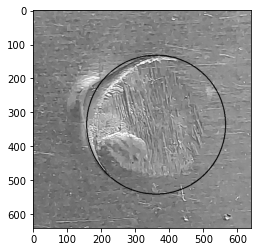

In [25]:
resized_input=cv2.resize(cropped_img,(640,640))
resized_gray=cv2.cvtColor(resized_input,cv2.COLOR_RGB2GRAY)
circle_img=resized_gray.copy()

cv2.circle(circle_img,(cx_resized,cy_resized),r_resized,(0,0),2)
plt.imshow(circle_img,cmap='gray')

In [26]:
circle=get_circle_coordinates(center=(cx_resized,cy_resized),radius=r_resized-15)

In [27]:
circle_int = [{'x': x, 'y': y, 'intensity': int(resized_gray[int(y)][int(x)])} for x, y in circle]
circle_int=pd.DataFrame(circle_int)
coord_x,coord_y=(circle_int[circle_int['intensity']>240]['x'].values),(circle_int[circle_int['intensity']>240]['y'].values)
arc_points = np.column_stack((coord_x, coord_y))
arc_mean=np.mean(arc_points)

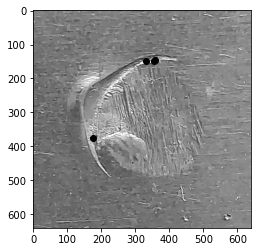

In [28]:
plt.imshow(resized_gray,cmap='gray')
plt.scatter(coord_x,coord_y,color='black')

In [29]:
# All the preprocessing required is done
resized_input=cv2.resize(cropped_img,(640,640))
resized_gray=cv2.cvtColor(resized_input,cv2.COLOR_RGB2GRAY)

copy=pre_process(resized_gray)
# copy=resized_gray

#Necessary Function Calls
profiles,angles= extract_radial_profiles(image=copy,cx=cx_resized,cy=cy_resized,radius=r_resized,angle_step=1)
min_points=min_int_points(profiles=profiles,angles=angles,cx=cx_resized,cy=cy_resized)
alpha_contour,centroid=get_smooth_alpha_shape_v2(img=pre_process(resized_gray),points=min_points,smooth=2.0,a=0.02)

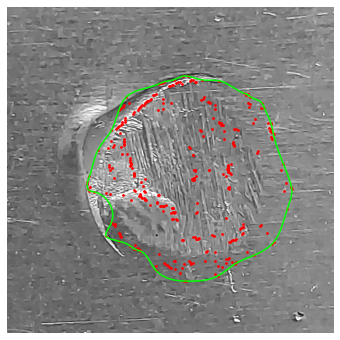

In [30]:
plt.figure(figsize=(6,6))
plt.axis('off')
plt.imshow(resized_gray,cmap='gray')
plt.scatter(min_points[:,0],min_points[:,1],color='red',s=3)
plt.plot(alpha_contour[:,0],alpha_contour[:,1],color='lime')

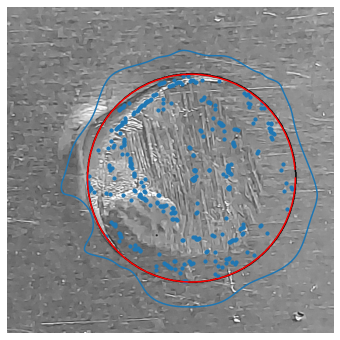

In [31]:
scaled_trial_2 = scale_polygon_points(alpha_contour, scale=1+(0.25)) 
# scaled_trial_1 = scale_polygon_points(alpha_contour, scale=1-(0.25))
plt.figure(figsize=(6,6))
plt.axis('off')
plt.imshow(circle_img,cmap='gray')
plt.plot(scaled_trial_2[:,0],scaled_trial_2[:,1])


trim_scaled=trim_points_inside_circle(points=scaled_trial_2,center=(cx_resized,cy_resized),radius=r_resized)
final_contour=merge_trim_with_circle_by_radial_sweep(trim_points=trim_scaled,circle_center=(cx_resized,cy_resized),radius=r_resized,resolution_deg=5)

plt.plot(final_contour[:,0],final_contour[:,1],color='red')

prof,ang=extract_radial_profiles_in_region(pre_process(resized_gray),cx_resized,cy_resized,r_resized,final_contour,angle_step=1)
points_region=min_int_points(prof,ang,cx=cx_resized,cy=cy_resized)

plt.scatter(points_region[:,0],points_region[:,1],s=10)
# smoothed_boundary = get_smooth_alpha_shape_v2(img=resized_gray,points=points_region, smooth=2)
# plt.plot(smoothed_boundary[:,0],smoothed_boundary[:,1],color='lime')

In [32]:
# # Iterative Convergence of Alpha Shape
# iter=10
# offset_x=0
# offset_y=0
# trial_iter = alpha_contour + np.array([offset_x, offset_y])
# for i in range(iter):
   
#     scaled_trial_2 = scale_polygon_points(trial_iter, scale=1+(0.5/(i+1))) 
#     scaled_trial_1 = scale_polygon_points(trial_iter, scale=1-(0.25/(i+1)))
#     region= np.vstack((scaled_trial_1, scaled_trial_2[::-1]))   
#     prof,ang=extract_radial_profiles_in_region(resized_gray,cx_resized,cy_resized,r_resized,region,angle_step=1)
#     points_region=min_int_points(prof,ang,cx=cx_resized,cy=cy_resized)
#     smoothed_boundary = smooth_closed_curve(points_region, smoothness=2*i)
#     plt.figure(figsize=(6,6))
#     plt.imshow(resized_gray,cmap='gray')
#     # plt.plot(points_region[:,0], points_region[:,1], 'o', label='Original points')
#     plt.title(f"Boundary after {i+1} iteration(s)")
#     plt.plot(smoothed_boundary[:,0], smoothed_boundary[:,1], '-', label='Smooth curve',color='lime')
#     plt.legend()
#     plt.axis('off')
#     # plt.savefig(rf'Detection_Trials\ {img_no} more fit.jpg',format='jpg',dpi=300)
#     plt.show()
#     x_smooth, y_smooth=smoothed_boundary[:,0],smoothed_boundary[:,1]
#     trial_iter=np.column_stack((x_smooth,y_smooth))
#     polygon = Polygon(trial_iter)
#     area_pixels = polygon.area
#     print(area_pixels)

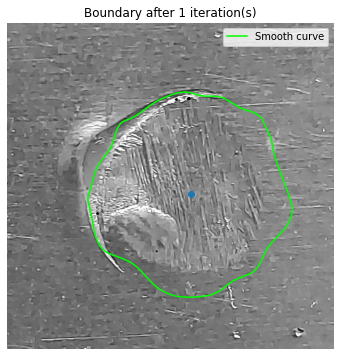

117706.4108706099


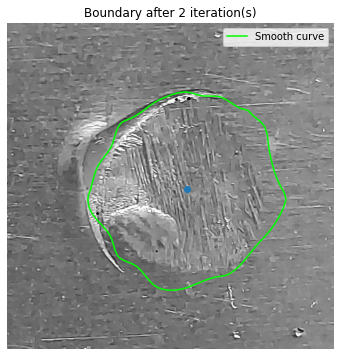

107643.10233652762


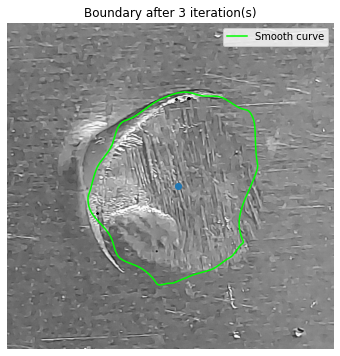

91835.80947894654


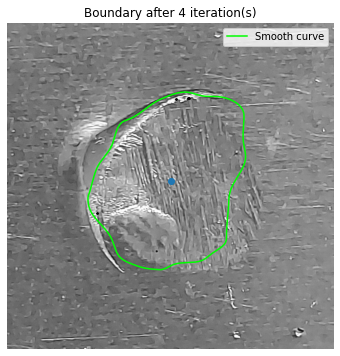

80093.15583251712


In [34]:
# Iterative Convergence of Alpha Shape
iter=4
offset_x=0
offset_y=0
trial_iter = alpha_contour + np.array([offset_x, offset_y])
r_iter=r_resized
for i in range(iter):
   
    scaled_trial_2 = scale_polygon_points(trial_iter, scale=1+(0.25/((i+1)*2))) 
    r_iter=r_resized
    trim_scaled=trim_points_inside_circle(points=scaled_trial_2,center=(cx_resized,cy_resized),radius=r_iter)   
    final_contour=merge_trim_with_circle_by_radial_sweep(trim_points=trim_scaled,circle_center=(cx_resized,cy_resized),radius=r_iter,resolution_deg=5)
    prof,ang=extract_radial_profiles_in_region(pre_process(resized_gray),cx_resized,cy_resized,r_iter,final_contour,angle_step=1)
    points_region=min_int_points(prof,ang,cx=cx_resized,cy=cy_resized)
    smoothed_boundary,centroid = get_smooth_alpha_shape_v2(img=resized_gray,points=points_region, smooth=0,a=0.01)
    # interpolated_points,_=get_smooth_alpha_shape_v2(img=resized_gray,points=np.vstack((smoothed_boundary,arc_points)),smooth=0)
    centroid=(centroid.x,centroid.y)
    direction=arc_mean-centroid
    norm = np.linalg.norm(direction)

    if norm != 0:
        unit_direction = direction / norm
    else:
        unit_direction = np.array([0.0, 0.0])

    plt.figure(figsize=(6,6))
    plt.imshow(resized_gray,cmap='gray')
    # plt.plot(points_region[:,0], points_region[:,1], 'o', label='Original points')
    plt.title(f"Boundary after {i+1} iteration(s)")
    plt.scatter(arc_points[:,0],arc_points[:,1],color='black',s=3)
    # plt.scatter(points_region[:,0],points_region[:,1],color='red',s=2)
    plt.plot(smoothed_boundary[:,0], smoothed_boundary[:,1], '-', label='Smooth curve',color='lime')
    # plt.plot(interpolated_points[:,0],interpolated_points[:,1],color='yellow')
    plt.scatter(centroid[0],centroid[1])
    plt.legend()
    plt.axis('off')
    plt.show()
    x_smooth, y_smooth=smoothed_boundary[:,0],smoothed_boundary[:,1]
    step_size = 30.0
    offset_x, offset_y = unit_direction * step_size

    trial_iter=np.column_stack((x_smooth,y_smooth))
    polygon = Polygon(trial_iter)
    area_pixels = polygon.area
    print(area_pixels)
    trial_iter=trial_iter +np.array([offset_x,offset_y])

In [35]:
import math
dist=smoothed_boundary-centroid
distances=[]
for i in dist:
    distances.append(math.sqrt(i[0]**2 + i[1]**2))

print(f"Max distance : {max(distances)}")

Max distance : 199.99248873293573


In [36]:
import math
dist=circle-centroid
distances=[]
for i in dist:
    distances.append(math.sqrt(i[0]**2 + i[1]**2))

print(f"Min distance from centroid to circle : {min(distances)}")

Min distance from centroid to circle : 140.03048252962736


In [37]:
width_per_pixel = 22 / 2604  # in mm
height_per_pixel = 41 / 4624  # in mm
x_scale = cropped_img.shape[1] /640
y_scale = cropped_img.shape[0] /640

In [38]:
area_pixels=np.round(80093.15583251712,2)
radius_pixels=np.round(140.03048252962736,2)
area_mm2=area_pixels*width_per_pixel*height_per_pixel*x_scale*y_scale
radius_mm=radius_pixels*width_per_pixel*x_scale
radius_mm=np.round(radius_mm,3)
area_mm2=np.round(area_mm2,3)
print(f'Area of spot: {area_mm2}')
print(f'Radius of Spot: {radius_mm}')

Area of spot: 27.271
Radius of Spot: 2.501


In [311]:
img_data=pd.DataFrame({'Spot No.':[1,2,3,4,6,7,8,9,10,11,12,14,15,16,17,18,19,20,21,22,23,24,25],
                       'Radius':[2.776,2.785,2.323,2.252,2.359,2.085,2.626,2.277,2.41,2.126,2.212,2.223,2.627,2.336,2.549,2.35,2.312,2.771,2.359,2.243,3.107,2.514,2.289],
                       'Spot Area':[28.856,28.458,23.074,21.848,22.517,20.796,np.NaN,17.806,20.056,21.172,19.163,21.302,27.583,22.1,25.241,19.953,23.594,26.673,19.779,21.923,22.588,23.288,21.476]},
                       columns=['Spot No.', 'Radius', 'Spot Area'])

In [ ]:
spot_no=img_no
img_data=pd.concat([img_data,pd.DataFrame({'Spot No.':spot_no,'Radius': radius_mm,'Spot Area':area_mm2},index=[spot_no])],ignore_index=True)

In [295]:
img_data

,Spot No.,Radius,Spot Area
0,1,2.776,28.856
1,2,2.785,28.458
2,3,2.323,23.074
3,4,2.252,21.848
4,6,2.359,22.517
5,7,2.085,20.796
6,8,2.626,NaN
7,9,2.277,17.806
8,10,2.410,20.056
9,11,2.126,21.172


## Workflow 2


In [119]:
#Load the YOLO model
model = YOLO('best.pt')

# Load the image in any size
img_no=68
img_path=rf"C:\Users\pavan kumar\OneDrive\Desktop\Internship Work Docs\Spot_Test\Spot Macro\{img_no}.jpg"
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


#results = model(img_path)

results = model(img_path,
                conf=0.1,
                iou=0.4,
                agnostic_nms=True,
                max_det=1)

#Get the bounding box coordinates
box = results[0].boxes.xyxy[0].detach().numpy()
x1, y1, x2, y2 = map(int, box)
x1_p, y1_p, x2_p, y2_p = expand_crop(x1, y1, x2, y2, 300, img.shape)
cropped_img = img[y1_p:y2_p, x1_p:x2_p]

# pass the cropped_img to detect circle
cx_resized,cy_resized,r_resized=detect_circle(cropped_img,350,450)


image 1/1 C:\Users\pavan kumar\OneDrive\Desktop\Internship Work Docs\Spot_Test\Spot Macro\68.jpg: 640x640 1 spot, 495.6ms
Speed: 14.0ms preprocess, 495.6ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)


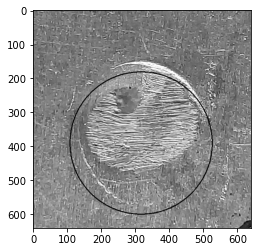

In [120]:
resized_input=cv2.resize(cropped_img,(640,640))
resized_gray=cv2.cvtColor(resized_input,cv2.COLOR_RGB2GRAY)
circle_img=resized_gray.copy()

cv2.circle(circle_img,(cx_resized,cy_resized),r_resized,(0,0),2)
plt.imshow(circle_img,cmap='gray')

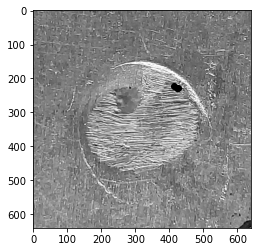

In [121]:
circle=get_circle_coordinates(center=(cx_resized,cy_resized),radius=r_resized-15)
circle_int = [{'x': x, 'y': y, 'intensity': int(resized_gray[int(y)][int(x)])} for x, y in circle]
circle_int=pd.DataFrame(circle_int)
coord_x,coord_y=(circle_int[circle_int['intensity']>240]['x'].values),(circle_int[circle_int['intensity']>240]['y'].values)
arc_points = np.column_stack((coord_x, coord_y))
arc_mean=np.mean(arc_points)
plt.imshow(resized_gray,cmap='gray')
plt.scatter(coord_x,coord_y,color='black')

In [122]:
resized_input=cv2.resize(cropped_img,(640,640))
resized_gray=cv2.cvtColor(resized_input,cv2.COLOR_RGB2GRAY)


copy=resized_gray

#Necessary Function Calls
profiles,angles= extract_radial_profiles(image=copy,cx=cx_resized,cy=cy_resized,radius=r_resized,angle_step=1)
min_points=min_int_points(profiles=profiles,angles=angles,cx=cx_resized,cy=cy_resized)
alpha_contour=get_smooth_alpha_shape(img=resized_gray,points=min_points,smooth=2.0)

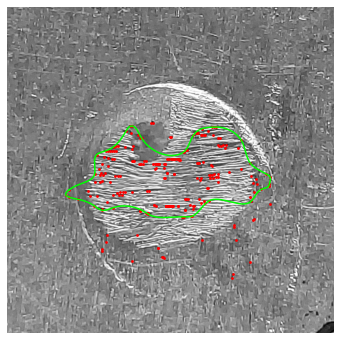

In [123]:
plt.figure(figsize=(6,6))
plt.axis('off')
plt.imshow(resized_gray,cmap='gray')
plt.scatter(min_points[:,0],min_points[:,1],color='red',s=3)
plt.plot(alpha_contour[:,0],alpha_contour[:,1],color='lime')

In [128]:
refined, index_map = refine_contour_directional_k_points(
    alpha_contour, resized_gray,
    cx_resized, cy_resized, r_resized,
    minimum=False, top_k=5
)

# Now:
# - `refined` is a flat list of points
# - `index_map[i]` tells you which points in `refined` came from original point `i`

# Example: visualize all new points for original point 0
print("Original point 0 mapped to new points:")
for idx in index_map[0]:
    print(refined[idx])

Original point 0 mapped to new points:
[239 503]
[238 502]
[246 512]
[245 511]
[240 504]


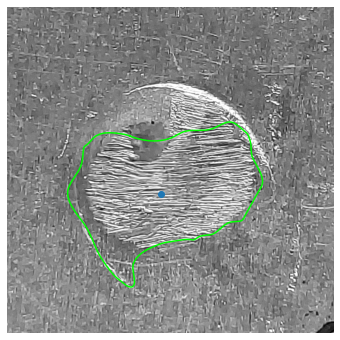

In [130]:
plt.figure(figsize=(6,6))
plt.axis('off')
plt.imshow(resized_gray,cmap='gray')
# plt.scatter(refined[:,0],refined[:,1],color='red',s=2)
smoo,centroid=get_smooth_alpha_shape_v3(resized_gray,refined,smooth=2,a=0.02)
plt.plot(smoo[:,0],smoo[:,1],color='lime')
plt.scatter(smoo[:,0].mean(),smoo[:,1].mean())

 Iteration No: 1
 Iteration No: 2
 Iteration No: 3


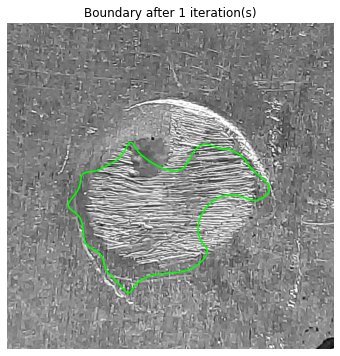

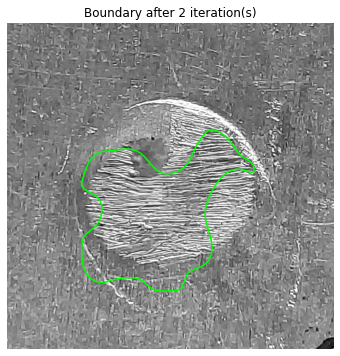

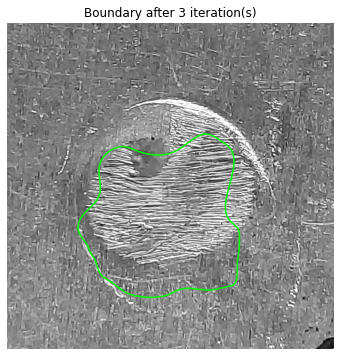

In [126]:
iterations=3
trial_iter=alpha_contour
offset_x,offset_y=0,0
for i in range(iterations):
    print(f" Iteration No: {i+1}")
    refined, index_map = refine_contour_directional_k_points(
    trial_iter, resized_gray,
    cx_resized, cy_resized, r_resized-(i*10),
    minimum=True, top_k=iterations -1)

    smoo,_=get_smooth_alpha_shape_v3(resized_gray,refined,smooth=2,a=0.02)
    centroid=(smoo[:,0].mean(),smoo[:,1].mean())

    direction=arc_mean-centroid
    norm = np.linalg.norm(direction)

    if norm != 0:
        unit_direction = direction / norm
    else:
        unit_direction = np.array([0.0, 0.0])

    step_size = 50.0
    offset_x, offset_y = unit_direction * step_size
    trial_iter=smoo +np.array([offset_x,offset_y])

    plt.figure(figsize=(6,6))
    plt.axis('off')
    plt.title(f'Boundary after {i+1} iteration(s)')
    plt.imshow(resized_gray,cmap='gray')
    plt.plot(smoo[:,0],smoo[:,1],color='lime')


In [134]:
import math
dist=smoo-(centroid.x,centroid.y)
distances=[]
for i in dist:
    distances.append(math.sqrt(i[0]**2 + i[1]**2))

print(f"Max distance : {max(distances)}")

Max distance : 201.29295167990963


In [135]:
width_per_pixel = 22 / 2604  # in mm
height_per_pixel = 41 / 4624  # in mm
x_scale = cropped_img.shape[1] /640
y_scale = cropped_img.shape[0] /640

In [136]:
area_pixels=np.round(85356.7826702757,2)
radius_pixels=np.round(201.29295167990963,2)
area_mm2=area_pixels*width_per_pixel*height_per_pixel*x_scale*y_scale
radius_mm=radius_pixels*width_per_pixel*x_scale
radius_mm=np.round(radius_mm,3)
print(radius_mm)

3.744


## Workflow 3


In [169]:
#Load the YOLO model
model = YOLO('best.pt')

# Load the image in any size
img_no=67
img_path=rf"C:\Users\pavan kumar\OneDrive\Desktop\Internship Work Docs\Spot_Test\Spot Macro\{img_no}.jpg"
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


#results = model(img_path)

results = model(img_path,
                conf=0.1,
                iou=0.4,
                agnostic_nms=True,
                max_det=1)

#Get the bounding box coordinates
box = results[0].boxes.xyxy[0].detach().numpy()
x1, y1, x2, y2 = map(int, box)
x1_p, y1_p, x2_p, y2_p = expand_crop(x1, y1, x2, y2, 300, img.shape)
cropped_img = img[y1_p:y2_p, x1_p:x2_p]

# pass the cropped_img to detect circle
cx_resized,cy_resized,r_resized=detect_circle(cropped_img,350,450)


image 1/1 C:\Users\pavan kumar\OneDrive\Desktop\Internship Work Docs\Spot_Test\Spot Macro\67.jpg: 640x640 1 spot, 372.0ms
Speed: 9.0ms preprocess, 372.0ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)


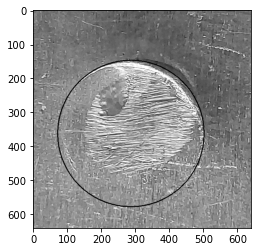

In [170]:
resized_input=cv2.resize(cropped_img,(640,640))
resized_gray=cv2.cvtColor(resized_input,cv2.COLOR_RGB2GRAY)
circle_img=resized_gray.copy()

cv2.circle(circle_img,(cx_resized,cy_resized),r_resized,(0,0),2)
plt.imshow(circle_img,cmap='gray')

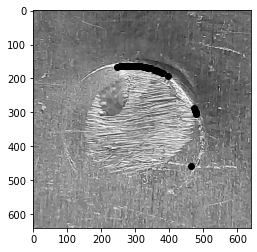

In [171]:
circle=get_circle_coordinates(center=(cx_resized,cy_resized),radius=r_resized-15)
circle_int = [{'x': x, 'y': y, 'intensity': int(resized_gray[int(y)][int(x)])} for x, y in circle]
circle_int=pd.DataFrame(circle_int)
coord_x,coord_y=(circle_int[circle_int['intensity']>240]['x'].values),(circle_int[circle_int['intensity']>240]['y'].values)
arc_points = np.column_stack((coord_x, coord_y))
arc_mean=np.mean(arc_points)
plt.imshow(resized_gray,cmap='gray')
plt.scatter(coord_x,coord_y,color='black')

In [159]:
resized_input=cv2.resize(cropped_img,(640,640))
resized_gray=cv2.cvtColor(resized_input,cv2.COLOR_RGB2GRAY)


copy=resized_gray



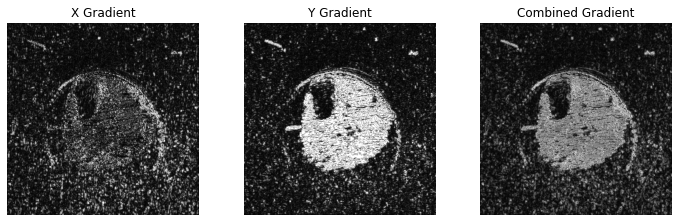

In [160]:
ksize=3
gx=cv2.Sobel(copy,ddepth=cv2.CV_32F,dx=1,dy=0,ksize=ksize)
gy=cv2.Sobel(copy,ddepth=cv2.CV_32F,dx=0,dy=1,ksize=ksize)

gx=cv2.convertScaleAbs(gx)
gy=cv2.convertScaleAbs(gy)

combined=cv2.addWeighted(gx,0.5,gy,0.5,0)

plt.figure(figsize=(12,12))
plt.subplot(3,3,1)
plt.imshow(gx,cmap='gray')
plt.title('X Gradient')
plt.axis('off')
plt.subplot(3,3,2)
plt.axis('off')
plt.title('Y Gradient')
plt.imshow(gy,cmap='gray')
plt.subplot(3,3,3)
plt.axis('off')
plt.title('Combined Gradient')
plt.imshow(combined,cmap='gray')

In [161]:
_, thresh = cv2.threshold(gy, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

In [162]:
kernel = np.ones((3, 3), np.uint8)
cleaned = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel, iterations=1)


In [163]:
contours, _ = cv2.findContours(cleaned, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Sort by area and pick the largest contour (likely your spot)
contours = sorted(contours, key=cv2.contourArea, reverse=True)
spot_contour = contours[0]

# Create mask from contour
mask = np.zeros_like(gy)
cv2.drawContours(mask, [spot_contour], -1, 255, thickness=-1)
cnt=spot_contour[:,0,:]
centroid=[cnt[:,0].mean(),cnt[:,1].mean()]

poly=Polygon(cnt)



72742.0


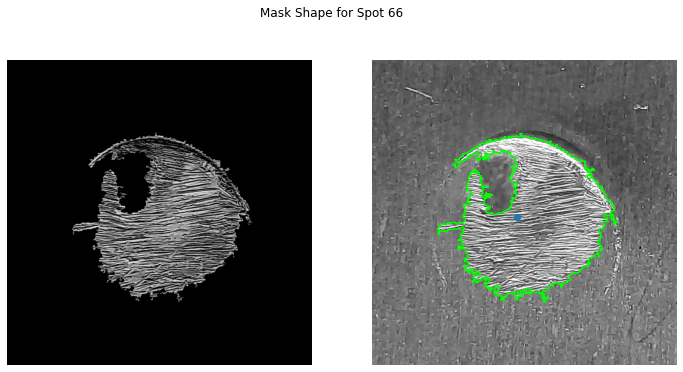

In [164]:
plt.figure(figsize=(12,6))
plt.suptitle(f'Mask Shape for Spot {img_no}')
plt.subplot(1,2,1)
plt.axis('off')
plt.imshow(mask*resized_gray,cmap='gray')
plt.subplot(1,2,2)
plt.axis('off')
plt.imshow(resized_gray,cmap='gray')
plt.plot(cnt[:,0],cnt[:,1],color='lime')
plt.scatter(centroid[0],centroid[1])
print(poly.area)

In [165]:
import math
dist=cnt-centroid
distances=[]
for i in dist:
    distances.append(math.sqrt(i[0]**2 + i[1]**2))

print(f"Max distance : {max(distances)}")

Max distance : 210.99976146884282


In [166]:
import math
dist=circle-centroid
distances=[]
for i in dist:
    distances.append(math.sqrt(i[0]**2 + i[1]**2))

print(f"Min distance : {max(distances)}")

Min distance : 252.8171032710723


In [167]:
width_per_pixel = 22 / 2604  # in mm
height_per_pixel = 41 / 4624  # in mm
x_scale = cropped_img.shape[1] /640
y_scale = cropped_img.shape[0] /640

In [168]:
area_pixels=np.round(72742.0,2)
radius_pixels=np.round(210.99976146884282,2)

area_mm2=area_pixels*width_per_pixel*height_per_pixel*x_scale*y_scale
area_mm2=np.round(area_mm2,3)

radius_mm=radius_pixels*width_per_pixel*x_scale
radius_mm=np.round(radius_mm,3)
print(f'Area of spot : {area_mm2}')
print(f'Radius of spot: {radius_mm}')

Area of spot : 24.265
Radius of spot: 3.908


In [172]:
img_data=pd.DataFrame({'Spot No.':[1,2,3,4,6,7,8,9,10,11,12,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,30,31,32,33,34,37,39,50,58,59,60,61,62,63,64,65,66],
                       'Radius':[2.776,2.785,2.323,2.252,2.359,2.085,2.626,2.277,2.41,2.126,2.212,2.223,2.627,2.336,2.549,2.35,2.312,2.771,2.359,2.243,3.107,2.514,2.289,2.283,3.278,2.575,2.069,2.082,2.538,2.506,2.377,3.973,4.424,2.501,2.475,2.428,np.NaN,3.673,3.831,3.85,3.922,3.915,3.908],
                       'Spot Area':[28.856,28.458,23.074,21.848,22.517,20.796,np.NaN,17.806,20.056,21.172,19.163,21.302,27.583,22.1,25.241,19.953,23.594,26.673,19.779,21.923,22.588,23.288,21.476,21.109,18.688,20.336,24.961,20.579,22.974,23.244,23.31,32.207,32.696,27.271,22.412,21.824,22.46,21.573,23.978,24.967,23.414,24.508,24.265]},
                       columns=['Spot No.', 'Radius', 'Spot Area'])

In [173]:
img_data

,Spot No.,Radius,Spot Area
0,1,2.776,28.856
1,2,2.785,28.458
2,3,2.323,23.074
3,4,2.252,21.848
4,6,2.359,22.517
5,7,2.085,20.796
6,8,2.626,NaN
7,9,2.277,17.806
8,10,2.410,20.056
9,11,2.126,21.172


## Siamese Network Worflow to classify images


In [ ]:

import torch
import torch.nn as nn


class FeatureExtractor(nn.Module):
    def __init__(self, input_size=(3, 64, 64)):  # Default input size
        super().__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),  # (B, 64, H, W)
            nn.ReLU(),
            nn.MaxPool2d(2),                             # (B, 64, H/2, W/2)
            nn.Conv2d(64, 32, kernel_size=3, padding=1), # (B, 32, H/2, W/2)
            nn.ReLU(),
            nn.MaxPool2d(2)                              # (B, 32, H/4, W/4)
        )

        # Compute flattened size automatically
        with torch.no_grad():
            dummy = torch.zeros(1, *input_size)
            flat_size = self.conv(dummy).view(1, -1).shape[1]

        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(flat_size, 128),
            nn.ReLU()
        )

    def forward(self, x):
        x = self.conv(x)
        x = self.fc(x)
        return x

class SiameseNetwork(nn.Module):
    def __init__(self, input_size=(3, 64, 64)):
        super().__init__()
        self.feature_extractor = FeatureExtractor(input_size)

    def forward(self, input1, input2):
        out1 = self.feature_extractor(input1)
        out2 = self.feature_extractor(input2)
        return out1, out2


model=SiameseNetwork()

In [378]:
from pathlib import Path
data_path=Path(r'data/')
train_dir=data_path/'train'
test_dir=data_path/'test'

In [ ]:
from torchvision import transforms
data_transform=transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

normal_transform=transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor()
])

In [380]:
from torchvision import datasets

train_data=datasets.ImageFolder(root=train_dir,
                                transform=data_transform,
                                target_transform=None)

test_data=datasets.ImageFolder(root=test_dir,
                               transform=normal_transform,
                               target_transform=None)

In [381]:
img_path_class_1=list(train_dir.glob('1/*.jpg'))
img_path_class_2=list(train_dir.glob('2/*.jpg'))
img_path_class_3=list(train_dir.glob('3/*.jpg'))

In [382]:
data_dict={
    '1':img_path_class_1,
    '2':img_path_class_2,
    '3':img_path_class_3
}

In [383]:
from torch.utils.data import DataLoader

BATCH_SIZE=1

train_dataloader=DataLoader(dataset=train_data,
                            batch_size=BATCH_SIZE,
                            num_workers=1,
                            shuffle=True)

test_dataloader=DataLoader(dataset=test_data,
                           batch_size=BATCH_SIZE,
                           num_workers=1,
                           shuffle=False)

In [388]:
import torch
from torch.utils.data import Dataset
from PIL import Image
import random

class SiamesePairDataset(Dataset):
    def __init__(self, image_paths_by_class, transform=None):
        self.data = image_paths_by_class  # {'1': [path1, path2, ...], ...}
        self.classes = list(self.data.keys())
        self.transform = transform
        self.pairs = self.generate_pairs()

    def generate_pairs(self):
        pairs = []

        # Positive pairs (same class, label = 0)
        for cls in self.classes:
            imgs = self.data[cls]
            for i in range(len(imgs)):
                for j in range(i + 1, len(imgs)):
                    pairs.append((imgs[i], imgs[j], 0))

        # Negative pairs (different classes, label = 1)
        for cls in self.classes:
            imgs = self.data[cls]
            other_classes = [c for c in self.classes if c != cls]
            for img1 in imgs:
                neg_cls = random.choice(other_classes)
                img2 = random.choice(self.data[neg_cls])
                pairs.append((img1, img2, 1))

        random.shuffle(pairs)  # Shuffle once
        return pairs

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        img1_path, img2_path, label = self.pairs[idx]

        img1 = Image.open(img1_path).convert('RGB')
        img2 = Image.open(img2_path).convert('RGB')

        if self.transform:
            img1 = self.transform(img1)
            img2 = self.transform(img2)

        return img1, img2, torch.tensor(label, dtype=torch.float32)


In [391]:
import torch.nn as nn
import torch.nn.functional as F

class ContrastiveLoss(nn.Module):
    def __init__(self, margin=1.0):
        super().__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        distance = F.pairwise_distance(output1, output2)
        loss = (1 - label) * torch.pow(distance, 2) + \
               label * torch.pow(torch.clamp(self.margin - distance, min=0.0), 2)
        return loss.mean()


In [393]:
import torch
from torch.utils.data import DataLoader

# --- Setup ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SiameseNetwork(input_size=(3, 64, 64)).to(device)
criterion = ContrastiveLoss(margin=1.0)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# --- Dataloader ---
train_dataset = SiamesePairDataset(data_dict, transform=data_transform)
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)

# --- Training ---
num_epochs = 5
model.train()

for epoch in range(num_epochs):
    running_loss = 0.0
    for img1, img2, label in train_loader:
        img1, img2, label = img1.to(device), img2.to(device), label.to(device)

        optimizer.zero_grad()
        out1, out2 = model(img1, img2)
        loss = criterion(out1, out2, label)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {avg_loss:.4f}")


Epoch [1/5] - Loss: 0.0950
Epoch [2/5] - Loss: 0.1001
Epoch [3/5] - Loss: 0.1073
Epoch [4/5] - Loss: 0.1073
Epoch [5/5] - Loss: 0.1073


In [399]:
(img1, label1) = test_data[0]
(img2, label2) = test_data[6]

# Preprocess (if needed) and move to device
img1 = img1.unsqueeze(0).to(device)
img2 = img2.unsqueeze(0).to(device)

# Get embeddings
threshold=0.5
model.eval()
with torch.no_grad():
    emb1 = model.feature_extractor(img1)
    emb2 = model.feature_extractor(img2)

    # Distance between embeddings
    dist = F.pairwise_distance(emb1, emb2)
    is_same = (dist < threshold).item()

    print(f"Predicted same class? {bool(is_same)}")
    print(f"Actual same class? {label1 == label2}")

Predicted same class? True
Actual same class? False


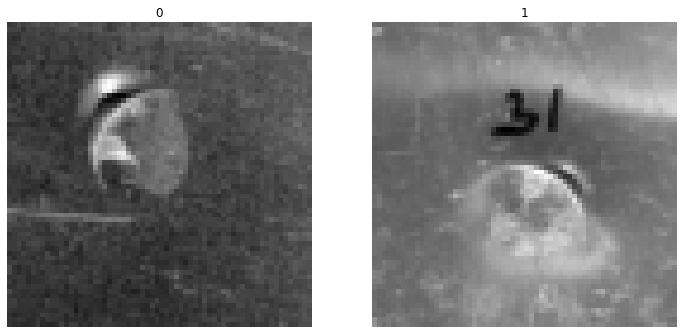

In [419]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.axis('off')
plt.title(label1)
plt.imshow(img1.squeeze(dim=0).numpy()[0,:,:],cmap='gray')
plt.subplot(1,2,2)
plt.axis('off')
plt.title(label2)
plt.imshow(img2.squeeze(dim=0).numpy()[0,:,:],cmap='gray')

# Spot Detection for different Dataset

The dataset i used here is different and there was no requrirement of YOLOv8 Model


(350, 350, 3)


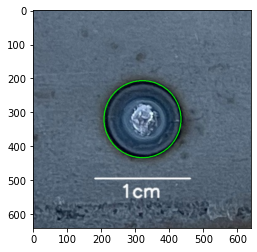

In [145]:
img_no=55
img_path=rf"C:\Users\pavan kumar\OneDrive\Desktop\Internship Work Docs\Resistance Spot Welding Insights A Dataset Integrating Process Parameters, Infrared, and Surface Imaging\RGB_B\RGB_{img_no}B.jpg"
img=cv2.imread(img_path)
print(img.shape)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

cx_resized,cy_resized,r_resized=detect_circle(img,10,200)

img=cv2.resize(img,(640,640))
circle=img.copy()
cv2.circle(circle,(cx_resized,cy_resized),r_resized,(0,255,0),2)
plt.imshow(circle)

In [146]:
resized_gray=cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
copy = cv2.equalizeHist(resized_gray)
sobel_x = cv2.Sobel(copy, cv2.CV_64F, 1, 0, ksize=3)
sobel_y = cv2.Sobel(copy, cv2.CV_64F, 0, 1, ksize=3)
sobel = cv2.magnitude(sobel_x, sobel_y)
sobel= cv2.convertScaleAbs(sobel)
copy = cv2.GaussianBlur(sobel, (5, 5), 0)

#Necessary Function Calls
profiles,angles= extract_radial_profiles(image=copy,cx=cx_resized,cy=cy_resized,radius=r_resized,angle_step=1)
min_points=min_int_points(profiles=profiles,angles=angles,cx=cx_resized,cy=cy_resized)
alpha_contour=get_smooth_alpha_shape(img=resized_gray,points=min_points)


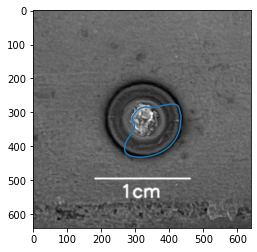

In [147]:
plt.imshow(resized_gray,cmap='gray')
plt.plot(alpha_contour[:,0],alpha_contour[:,1])

Iteration No: 1


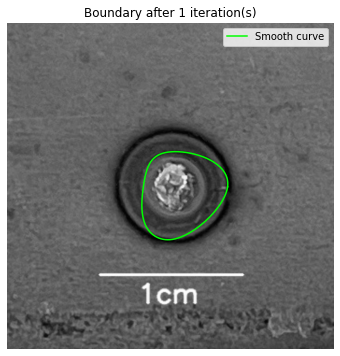

Iteration No: 2


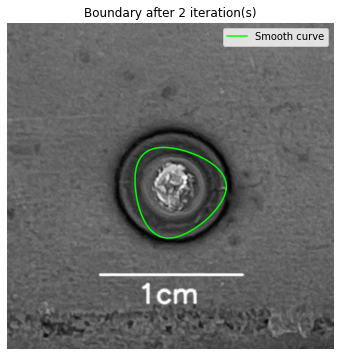

Iteration No: 3


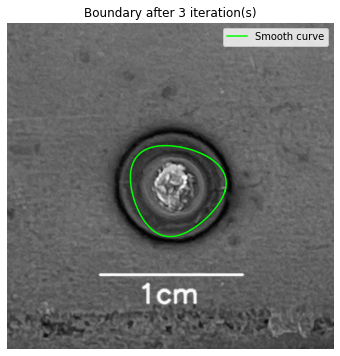

In [148]:
iter=3
trial_iter=alpha_contour
for i in range(iter):
    print(f"Iteration No: {i+1}")
   
    scaled_trial_2 = scale_polygon_points(trial_iter, scale=1+(0.5/(i+1))) 
    scaled_trial_1 = scale_polygon_points(trial_iter, scale=1-(0.25/(i+1)))
    region= np.vstack((scaled_trial_1, scaled_trial_2[::-1]))   
    prof,ang=extract_radial_profiles_in_region(resized_gray,cx_resized,cy_resized,r_resized,region,angle_step=1)
    points_region=min_int_points(prof,ang,cx=cx_resized,cy=cy_resized)
    smoothed_boundary = smooth_closed_curve(points_region, smoothness=80000 + 10*i)
    plt.figure(figsize=(6,6))
    plt.imshow(resized_gray,cmap='gray')
    # plt.plot(points_region[:,0], points_region[:,1], 'o', label='Original points')
    plt.title(f"Boundary after {i+1} iteration(s)")
    plt.plot(smoothed_boundary[:,0], smoothed_boundary[:,1], '-', label='Smooth curve',color='lime')
    plt.legend()
    plt.axis('off')
    # plt.savefig(rf'Detection_Trials\ {img_no} more fit.jpg',format='jpg',dpi=300)
    plt.show()
    x_smooth, y_smooth=smoothed_boundary[:,0],smoothed_boundary[:,1]
    trial_iter=np.column_stack((x_smooth,y_smooth))